# FastAI integration for Data Science Bowl 2018

This notebook presents my work to try and use the fastai library to tackle the data science bowl 2018 kaggle competition. 

In [105]:
import os
import sys
import random
import warnings
import time
import copy

from math import ceil
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import PIL

import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import fastai.vision as v
from fastai.vision.data import SegmentationItemList, SegmentationLabelList
from fastai.vision.image import open_image, Image
from fastai.vision.transform import rand_pad
from fastai.vision.learner import unet_learner
import fastai.vision.models as mod
from fastai.callbacks import SaveModelCallback
from fastai.basic_data import DatasetType

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.transforms.functional as TF

# IMAGE SIZES
TRAIN_WIDTH = 256
TRAIN_HEIGHT = 256
MAX_WIDTH = 1388
MAX_HEIGHT = 1388
TEST_HEIGHT = 256
TEST_WIDTH = 256
TEST_OVERLAP = 64
IMG_CHANNELS = 3

# PATHS
PROJECT_PATH = '/work/stages/schwob/data-science-bowl-2018/kaggle-dsbowl-2018/'
TRAIN_PATH = PROJECT_PATH+'data/stage1_train/'
TEST_PATH = PROJECT_PATH+'data/stage2_test_final/'
MODELS_PATH = PROJECT_PATH+'models/'
SUB_PATH = PROJECT_PATH+'submissions/'

# NORMALIZE
MEAN = (0.5, 0.5, 0.5)
STD = (0.5, 0.5, 0.5)

# LEARNER CONFIG
BATCH_SIZE = 4
WD = 0.1
LR = 2e-4
EPOCHS = 10
MODEL = "resnet34"


warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

We define the models we want to be able to use.

In [106]:
models = {'resnet34': mod.resnet34, 'resnet50': mod.resnet50, 'resnet101': mod.resnet101}

## Loading data

We first need to create a custom `SegmentationLabelList` for our masks as they are stored in multiple files. To do so, we mainly need to override the `open` function to create the full mask from the multiple images. The path that is stored in the list will therefore be the path to the folder containing all the masks. I also added the `erosion` variable that determines if we erode the masks to make all nuclei borders have a clear separation.

In [107]:
class MultiMasksList(SegmentationLabelList):
    def __init__(self, *args, erosion=True, **kwargs):
        super().__init__(*args, **kwargs)
        self.erosion = erosion

    def open(self, fn):
        mask_files = next(os.walk(fn))[2]
        mask = open_image(os.path.join(fn, mask_files.pop(0)),
                          convert_mode='L').px
        for mask_file in mask_files:
            mask += open_image(os.path.join(fn, mask_file),
                               convert_mode='L').px
        if self.erosion:
            mask = torch.tensor(
                cv2.erode(
                    mask.numpy().squeeze().astype(np.uint8),
                    np.ones((3, 3),
                            np.uint8),
                    iterations=1)).unsqueeze(0)
        return Image(mask.float())

    def analyze_pred(self, pred, thresh: float = 0.5):
        return (pred > thresh).float()

    def reconstruct(self, t): return Image(t)

After that, we can directly load the data from the training folder. We get all the png images and only keep those that are in an `images` folder. We randomly crop the images to make them all have the same size , and normalize them to [-1,1] range (it got me better result for some reason).

In [108]:
def load_data(path, size=256, bs=8, val_split=0.2,
              erosion=True, normalize=None, testset=None):
    train_list = (
        SegmentationItemList.
        from_folder(path, extensions=['.png']).
        filter_by_func(lambda fn: Path(fn).parent.name == 'images').
        split_by_rand_pct(valid_pct=val_split).
        label_from_func(
            lambda x: x.parents[1] / 'masks/', label_cls=MultiMasksList,
            classes=['nucl'], erosion=erosion).transform(
            (rand_pad(0, size), rand_pad(0, size)), tfm_y=True))
    if testset:
        train_list.test = testset
    train_list = train_list.databunch(bs=bs, num_workers=0)
    if normalize:
        train_list = train_list.normalize(
            [torch.tensor(normalize[0]),
             torch.tensor(normalize[1])])
    return train_list

In [109]:
db = load_data(TRAIN_PATH, bs=BATCH_SIZE)

## Augment data
I did some data augmentation that I directly stored in disk using the follow function. It basically randomly changes HUE, brightness and contrast of the image, additionnaly to flipping it with probability 0.5 and applying a random affine transform. It is not necessary to use for starters but it helps improving the score.

In [110]:
def get_affine(degrees, scale_ranges, shears):
    angle = random.uniform(degrees[0], degrees[1])

    if scale_ranges is not None:
        scale = random.uniform(scale_ranges[0], scale_ranges[1])
    else:
        scale = 1.0

    if shears is not None:
        shear = random.uniform(shears[0], shears[1])
    else:
        shear = 0.0

    return angle, scale, shear

def getNextId(output_folder):
    highest_num = -1
    for d in os.listdir(output_folder):
        dir_name = os.path.splitext(d)[0]
        try:
            i = int(dir_name)
            if i > highest_num:
                highest_num = i
        except ValueError:
            'The dir name "%s" is not an integer. Skipping' % dir_name

    new_id = highest_num + 1
    return new_id

def augment_data(path, hue_range=0.05, brightness_range=0.2,
                 contrast_range=0.2, p_hue=0.8, p_brightness=0.8,
                 p_contrast=0.8, max_rot=180, max_scale=0.1,
                 max_shear=10, p_hflip=0.5):
    ids = next(os.walk(path))[1]

    for i in ids:
        tfms = [transforms.Grayscale()]
        mask_tfms = []

        if random.random() < p_hue:
            tfms.append(transforms.Lambda(lambda x: TF.adjust_hue(
                x, random.uniform(-hue_range, hue_range))))
        if random.random() < p_brightness:
            tfms.append(transforms.Lambda(lambda x: TF.adjust_brightness(
                x, random.uniform(1-brightness_range,
                                  1+brightness_range))))
        if random.random() < p_contrast:
            tfms.append(transforms.Lambda(lambda x: TF.adjust_contrast(
                x, random.uniform(1-contrast_range,
                                  1+contrast_range))))

        angle, scale, shear = get_affine((-max_rot, max_rot),
                                         (1-max_scale, 1+max_scale),
                                         (-max_shear, max_shear))
        affine = transforms.Lambda(lambda x: TF.affine(x, angle, (0, 0),
                                                       scale, shear))
        tfms.append(affine)
        mask_tfms.append(affine)

        if random.random() < p_hflip:
            hflip = transforms.Lambda(lambda x: TF.hflip(x))
            tfms.append(hflip)
            mask_tfms.append(hflip)

        tfms.append(transforms.Grayscale(3))
        tfms = transforms.Compose(tfms)
        mask_tfms = transforms.Compose(mask_tfms)

        augs_path = os.path.join(path, i, 'augs')
        if not os.path.exists(augs_path):
            os.makedirs(augs_path)
        new_id = str(getNextId(augs_path))
        os.makedirs(os.path.join(augs_path, new_id))
        os.makedirs(os.path.join(augs_path, new_id, 'images'))
        os.makedirs(os.path.join(augs_path, new_id, 'masks'))

        img = imread(os.path.join(path, i, 'images', f'{i}.png'))
        img = PIL.Image.fromarray(img)
        img = tfms(img)
        img.save(os.path.join(augs_path, new_id, 'images', f'{new_id}.png'))

        mask_path = os.path.join(path, i, 'masks')
        for k, mask_file in enumerate(next(os.walk(mask_path))[2]):
            mask = imread(os.path.join(mask_path, mask_file))
            mask = PIL.Image.fromarray(mask)
            mask = mask_tfms(mask)
            mask.save(os.path.join(augs_path, new_id, 'masks',
                                   f'{new_id}_{k}.png'))

## Metric
The competition is evaluated using a variation of Intersection over Union (IoU). You can find an explanation [here](https://www.kaggle.com/c/data-science-bowl-2018/overview/evaluation) and a detailed explanation [there](https://www.kaggle.com/stkbailey/step-by-step-explanation-of-scoring-metric). All in all, I did a custom implementation which gives me quite accurate results.

In [111]:
def mean_iou(y_pred, y_true, smooth=1e-6):
    scores = np.zeros(y_true.shape[0])
    y_true = y_true.squeeze(1)
    y_pred = torch.sigmoid(y_pred).squeeze(1)
    for i in range(y_true.shape[0]):
        labels_pred = label(y_pred.to('cpu').numpy()[i] > 0.5)
        labels_true = label(y_true.to('cpu').numpy()[i])
        score = 0
        cnt = 0
        n_masks_pred = np.max(labels_pred)
        n_masks_true = np.max(labels_true)
        inter_union = np.zeros((n_masks_pred, n_masks_true, 2), dtype=np.int)
        for k in range(y_true.shape[1]):
            for l in range(y_true.shape[2]):
                m = labels_pred[k, l]
                n = labels_true[k, l]
                if m != 0:
                    inter_union[m-1, :, 1] += 1
                if n != 0:
                    inter_union[:, n-1, 1] += 1
                if m != 0 and n != 0:
                    inter_union[m-1, n-1, 0] += 1
        ious = inter_union[:, :, 0]/(
            inter_union[:, :, 1]-inter_union[:, :, 0]+smooth)
        for t in np.arange(0.5, 1.0, 0.05):
            cnt += 1
            tp = 0
            fp = 0
            fn = 0
            fn_tests = np.ones(n_masks_true, dtype=np.bool)
            for m in range(n_masks_pred):
                fp_test = True
                for n in range(n_masks_true):
                    if ious[m, n] > t:
                        tp += 1
                        fp_test = False
                        fn_tests[n] = False
                if fp_test:
                    fp += 1
            fn = np.count_nonzero(fn_tests)
            try:
                score += tp/(tp+fp+fn)
            except ZeroDivisionError:
                pass
        score = score/cnt
        scores[i] = score
    return torch.tensor(scores).mean()

## Training
We can now start doing some training. For now I'm using a Unet with the encoder being a resnet34 (ideally I would use resnet101 but I can't store it in GPU). I use the one-cycle policy with lr of 2e-4 (I used the `lr_find` function to find it) and weight decay of 0.1. For the loss we use `BCEWithLogitsLoss` which is binary cross-entropy but before the last sigmoid activation. It is apparently more robust, and the fastai unet model doesn't include a sigmoid, so we have to use it. Just don't forget to add sigmoid manually at the end when doing predictions.

In [112]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
learner = unet_learner(db, models[MODEL], pretrained=False, metrics=[mean_iou],
                       loss_func=nn.BCEWithLogitsLoss(), wd=WD, model_dir=MODELS_PATH)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


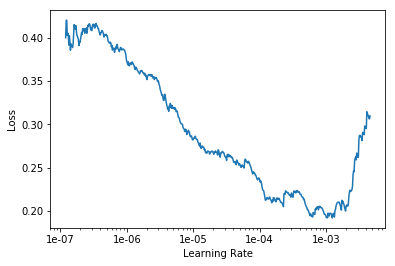

In [9]:
learner.lr_find(num_it=1000)
learner.recorder.plot()

Best model is saved in a file whose name contains the main training parameters.

In [113]:
def getNextFilePath(output_folder, base_name):
    highest_num = 0
    for f in os.listdir(output_folder):
        if os.path.isfile(os.path.join(output_folder, f)):
            file_name = os.path.splitext(f)[0]
            try:
                if file_name.split('_')[:-1]==base_name.split('_'):
                    split = file_name.split('.')
                    split = split[-1].split('_')
                    file_num = int(split[-1])
                    if file_num > highest_num:
                        highest_num = file_num
            except ValueError:
                'The file name "%s" is incorrect. Skipping' % file_name

    output_file = highest_num + 1
    return output_file

In [114]:
save_name = f'{MODEL}_{EPOCHS}_{LR}_{WD}'
save_name += f'_{getNextFilePath(MODELS_PATH, save_name)}'

In [12]:
learner.fit_one_cycle(EPOCHS, LR,callbacks=[SaveModelCallback(learner, monitor='mean_iou', name=save_name)])

epoch,train_loss,valid_loss,mean_iou,time
0,0.125511,0.110117,0.266939,12:27
1,0.100846,0.189240,0.211637,12:12
2,0.097377,0.149232,0.287370,12:28
3,0.091068,0.088360,0.351438,12:26
4,0.090539,0.075750,0.401964,12:52
5,0.068973,0.148001,0.298675,16:39
6,0.067974,0.063971,0.422603,17:53
7,0.060504,0.066162,0.421434,21:30
8,0.055556,0.069230,0.440475,20:52
9,0.053779,0.056820,0.465865,21:33


Better model found at epoch 0 with mean_iou value: 0.26693856050342707.
Better model found at epoch 2 with mean_iou value: 0.28737044776637355.
Better model found at epoch 3 with mean_iou value: 0.3514382779076678.
Better model found at epoch 4 with mean_iou value: 0.4019640999316581.
Better model found at epoch 6 with mean_iou value: 0.4226030738870484.
Better model found at epoch 8 with mean_iou value: 0.4404749742124597.
Better model found at epoch 9 with mean_iou value: 0.4658651878932147.


## Predictions
We can now predict on test set by loading the best model. But first, we need to load the testset. To do that I created a custom pytorch dataset that is for now overly complicated as I formerly used it for trainset as well.

In [115]:
class CellsDataset(Dataset):
    def __init__(self, path, ids, height=256, width=256, train=True,
                 erosion=True, normalize=None, crop=True, resize=False,
                 pad=False, grayscale=True, aug=True):
        self.path = path
        self.ids = ids
        self.height = height
        self.width = width
        self.c = 1
        self.erosion = erosion
        self.normalize = normalize
        self.resize = resize
        self.crop = crop
        self.grayscale = grayscale
        self.train = train
        self.aug = aug
        self.pad = pad

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        ids = np.array(self.ids[idx], ndmin=1)
        images = []
        masks = []
        sizes = []
        for i in ids:
            tfms = []
            mask_tfms = []

            if self.aug:
                augs_path = os.path.join(self.path, i, 'augs')
                spl = i.split('_')
                if len(spl) == 1:
                    img_path = os.path.join(
                        self.path, i, 'images', f'{i}.png')
                    mask_path = os.path.join(self.path, i, 'masks')
                else:
                    augs_path = os.path.join(self.path, spl[0], 'augs')
                    img_path = os.path.join(augs_path, spl[1],
                                            'images', f'{spl[1]}.png')
                    mask_path = os.path.join(augs_path, spl[1], 'masks')
            else:
                img_path = os.path.join(self.path, i, 'images', f'{i}.png')
                mask_path = os.path.join(self.path, i, 'masks')
            img = imread(img_path)
            try:
                img.shape[2]
            except IndexError:
                img = np.expand_dims(img, axis=2)
                img = np.concatenate((img, img, img), axis=2).astype(np.uint8)
            sizes.append(torch.tensor(img.shape).unsqueeze(0))
            img = PIL.Image.fromarray(img)

            if self.grayscale:
                tfms.append(transforms.Grayscale(3))

            if self.crop:
                i, j, th, tw = self.__get_crop(img)
                crop = transforms.Lambda(lambda x: TF.crop(x, i, j, th, tw))
                tfms.append(crop)
                mask_tfms.append(crop)

            if self.resize:
                resize = transforms.Resize((self.height, self.width))
                tfms.append(resize)
                mask_tfms.append(resize)

            if self.pad:
                assert (self.train is False and self.width >= img.width
                        and self.height >= img.height)
                pad = transforms.Pad((0, 0, self.width-img.width,
                                      self.height-img.height))
                tfms.append(pad)

            tfms.append(transforms.ToTensor())
            mask_tfms.append(transforms.ToTensor())

            if self.normalize:
                tfms.append(transforms.Normalize(self.normalize[0],
                                                 self.normalize[1]))

            transform = transforms.Compose(tfms)
            mask_transform = transforms.Compose(mask_tfms)
            images.append(transform(img).unsqueeze(0))

            if self.train:
                masks.append(self.__get_mask(mask_path, mask_transform))

        if self.train:
            return torch.cat(images).squeeze(), torch.cat(masks)
        else:
            return torch.cat(images).squeeze(), torch.cat(sizes).squeeze()

    def show(self, idx):
        img = self.__getitem__(idx)
        img = np.asarray(TF.to_pil_image(img))
        imshow(img)
        plt.show()
        return img

    def __get_crop(self, img):
        w, h = img.size
        th, tw = self.height, self.width
        if w == tw and h == th:
            return 0, 0, h, w

        i = random.randint(0, h - th)
        j = random.randint(0, w - tw)
        return i, j, th, tw

    def __get_mask(self, mask_path, transform):
        mask = torch.zeros((self.height, self.width))
        for mask_file in next(os.walk(mask_path))[2]:
            mask_ = imread(os.path.join(mask_path, mask_file))
            if self.erosion:
                mask_ = cv2.erode(
                    mask_.astype(np.uint8),
                    np.ones((3, 3),
                            np.uint8),
                    iterations=1)
            mask_ = PIL.Image.fromarray(mask_)
            mask_ = transform(mask_)
            mask = mask + mask_
        return mask

In [116]:
test_ids = next(os.walk(TEST_PATH))[1]
testset = CellsDataset(TEST_PATH, test_ids, height=MAX_HEIGHT, width=MAX_WIDTH,
                       train=False, erosion=True, crop=False, resize=False, aug=False,
                       pad=True)
db = load_data(TRAIN_PATH, size=TRAIN_WIDTH, bs=BATCH_SIZE, testset=testset)

Now we check on our models and reload the learner with the completed databunch and the trained model.

In [117]:
!ls models

resnet34_100_0.0002_0.1_1.pth  resnet34_150_0.0002_0.1_1.pth  tmp.pth
resnet34_10_0.0002_0.1_1.pth   resnet34_500_0.0002_0.1_1.pth


In [118]:
learner = unet_learner(db, models[MODEL], pretrained=False, metrics=[mean_iou],
                       loss_func=nn.BCEWithLogitsLoss(), wd=WD, model_dir=MODELS_PATH)
learner.load('resnet34_100_0.0002_0.1_1')

Learner(data=ImageDataBunch;

Train: LabelList (4824 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiMasksList
Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256)
Path: /work/stages/schwob/data-science-bowl-2018/kaggle-dsbowl-2018/data/stage1_train;

Valid: LabelList (1206 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiMasksList
Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256)
Path: /work/stages/schwob/data-science-bowl-2018/kaggle-dsbowl-2018/data/stage1_train;

Test: <__main__.CellsDataset object at 0x7f80a40fab38>, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, mome

To make prediction, I use Test Time Augments (rotations+flip for now) on crops of the images that overlap. I then reconstruct the final mask using these results.

In [119]:
def get_crops(img, size, overlap):
    n, h, w = img.size()
    n_h = max(1, ceil((h-size[0])/(size[0]-overlap)))
    n_w = max(1, ceil((w-size[1])/(size[1]-overlap)))
    crops = []
    pos = []
    overlaps = torch.zeros((h, w))
    for i in range(n_h):
        for j in range(n_w):
            crop = torch.zeros((n, size[0], size[1]))
            x_min = i*(size[0]-overlap)
            y_min = j*(size[1]-overlap)
            x_max = min(h, (i+1)*size[0]-i*overlap)
            y_max = min(w, (j+1)*size[1]-j*overlap)
            crop[:, :x_max-x_min, :y_max-y_min] = img[:, x_min:x_max,
                                                      y_min:y_max]
            crops.append(crop)
            overlaps[x_min:x_max, y_min:y_max] += 1
            pos.append(((x_min, y_min), (x_max, y_max)))
    return crops, pos, overlaps

In [120]:
def predict_TTA(learner, img, size, rotations, device):
    flipped = TF.hflip(img)
    res = torch.zeros(size)
    for angle in rotations:
        rot = TF.rotate(img, angle)
        rot = TF.to_tensor(rot).unsqueeze(0).to(device)
        rot_flipped = TF.rotate(flipped, angle)
        rot_flipped = TF.to_tensor(rot_flipped).unsqueeze(0).to(device)

        out_rot = learner.model(rot).cpu().squeeze()
        out_rot = torch.sigmoid(out_rot).squeeze()
        out_rot = TF.rotate(TF.to_pil_image(out_rot), -angle)
        out_rot = TF.to_tensor(out_rot).squeeze()

        out_flipped = learner.model(rot_flipped).cpu().squeeze()
        out_flipped = torch.sigmoid(out_flipped).squeeze()
        out_flipped = TF.hflip(TF.rotate(TF.to_pil_image(out_flipped), -angle))
        out_flipped = TF.to_tensor(out_flipped).squeeze()

        res += (out_rot+out_flipped)/2
    res /= len(rotations)
    return res

In [121]:
def predict_TTA_all(learner, size=(512, 512), overlap=64,
                    rotations=(0, 90, 180, 270), device='cuda:0'):
    preds = []
    sizes = []
    with torch.no_grad():
        for X_test, sizes_test in tqdm(learner.dl(DatasetType.Test)):
            sizes.append(sizes_test)
            for tens, s in zip(X_test, sizes_test):
                crops, pos, overlaps = get_crops(tens.cpu()[:, :s[0], :s[1]],
                                                 size, overlap)
                pred = torch.zeros((s[0], s[1]))
                for crop, ((x_min, y_min), (x_max, y_max)) in zip(crops, pos):
                    img = TF.to_pil_image(crop)
                    res = predict_TTA(learner, img, size, rotations, device)
                    pred[x_min:x_max, y_min:y_max] += res[
                        :x_max-x_min, :y_max-y_min]
                pred /= overlaps
                preds.append(pred.numpy())
    sizes = torch.cat(sizes).cpu().numpy().squeeze()
    return preds, sizes

In [88]:
preds, sizes = predict_TTA_all(learner, size=(TEST_HEIGHT, TEST_WIDTH), overlap=TEST_OVERLAP, device=device)

We then create the submission file using rle encoding

In [122]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev+1):
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    mask = np.zeros_like(lab_img)
    for i in range(1, lab_img.max() + 1):
        img = ((lab_img == i).astype(np.uint8) * 255)
        img = cv2.dilate(img, np.ones((3, 3), np.uint8),
                         iterations=1).astype('float32')/255
        mask[img > cutoff] = i
    for i in range(1, mask.max() + 1):
        yield rle_encoding(mask == i)

In [123]:
def create_submission(preds, sizes, test_ids, folder, resize=False):
    if resize:
        preds_test_upsampled = []
        for i, pred in enumerate(preds):
            preds_test_upsampled.append(resize(
                                        pred, (sizes[i, 0], sizes[i, 1]),
                                        mode='constant', preserve_range=True))
    else:
        preds_test_upsampled = preds
    new_test_ids = []
    rles = []
    for n, id_ in enumerate(tqdm(test_ids)):
        rle = list(prob_to_rles(preds_test_upsampled[n]))
        rles.extend(rle)
        if rle == []:
            rles.append([])
        new_test_ids.extend([id_] * max(1, len(rle)))

    sub = pd.DataFrame()
    sub['ImageId'] = new_test_ids
    sub['EncodedPixels'] = pd.Series(rles).apply(
        lambda x: ' '.join(str(y) for y in x))

    sub_file = os.path.join(folder,
                            f'sub_dsbowl_pt_{getNextFilePath(folder, "sub_dsbowl_pt")}.csv')
    sub.to_csv(sub_file, index=False)

In [94]:
create_submission(preds, sizes, test_ids, SUB_PATH)

/work/stages/schwob/.conda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


Once this is done, we can check four our latest submission and upload it on kaggle

In [124]:
!ls submissions

sub_dsbowl_pt_10.csv  sub_dsbowl_pt_18.csv  sub_dsbowl_pt_3.csv
sub_dsbowl_pt_11.csv  sub_dsbowl_pt_19.csv  sub_dsbowl_pt_4.csv
sub_dsbowl_pt_12.csv  sub_dsbowl_pt_1.csv   sub_dsbowl_pt_5.csv
sub_dsbowl_pt_13.csv  sub_dsbowl_pt_20.csv  sub_dsbowl_pt_6.csv
sub_dsbowl_pt_14.csv  sub_dsbowl_pt_21.csv  sub_dsbowl_pt_7.csv
sub_dsbowl_pt_15.csv  sub_dsbowl_pt_22.csv  sub_dsbowl_pt_8.csv
sub_dsbowl_pt_16.csv  sub_dsbowl_pt_23.csv  sub_dsbowl_pt_9.csv
sub_dsbowl_pt_17.csv  sub_dsbowl_pt_2.csv


In [97]:
!kaggle competitions submit data-science-bowl-2018 -f submissions/sub_dsbowl_pt_23.csv -m "Message"

OSError: [Errno 12] Cannot allocate memory

In [293]:
def read_rle(file, i):
    df = pd.read_csv(file)
    rles = df.loc[df['ImageId']==i, 'EncodedPixels']
    img = cv2.imread(os.path.join(TEST_PATH, i, 'images', f'{i}.png'), cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = np.zeros(img.shape[:2])
    for index, rle in rles.items():
        rle = list(map(int, rle.split(' ')))
        for k in range(0, len(rle), 2):
            for p in range(rle[k], rle[k]+rle[k+1]):
                x = (p-1)%mask.shape[0]
                y = (p-1)//mask.shape[0]
                mask[x, y] = index+1
    return img, mask

In [294]:
def norm_stand(img):
    img_nonull = np.where(img>0, img, np.nan)
    img = img/255
    img = (img-np.mean(img))/np.std(img)
    imax = np.max(img)
    imin = np.min(img)
    print(np.mean(img))
    return (img-imin)/(imax-imin)

In [297]:
img, mask = read_rle(os.path.join(SUB_PATH, 'sub_dsbowl_pt_19.csv'), test_ids[0])

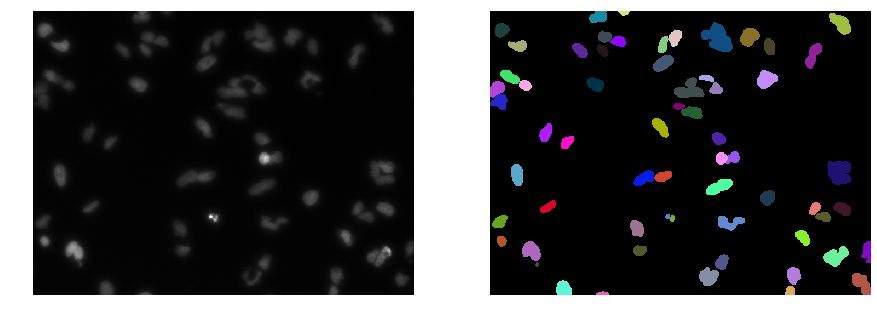

In [298]:
from matplotlib.colors import ListedColormap
null_img = np.where(img>0, 1, 0)
f = plt.figure(num=0, figsize=(15,15))
rand_cmap = ListedColormap(np.random.rand(256,3))
rand_cmap.set_bad(color='black')
plt.subplot(121)
plt.axis('off')
plt.imshow(img, cmap='gray')
plt.subplot(122)
plt.axis('off')
plt.imshow(np.where(mask>0, mask, np.nan), cmap=rand_cmap)